In [17]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import matplotlib.pyplot as  plt
import seaborn as sns
%matplotlib inline

In [18]:
bike_rentals=pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


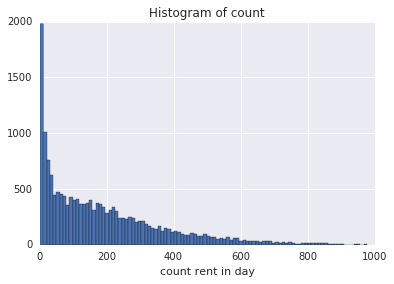

In [19]:
plt.hist(bike_rentals['cnt'],100)
plt.xlabel("count rent in day")
plt.title('Histogram of count')
plt.grid(True)
plt.show()



In [20]:
corr_matrix=bike_rentals.corr(method='pearson')

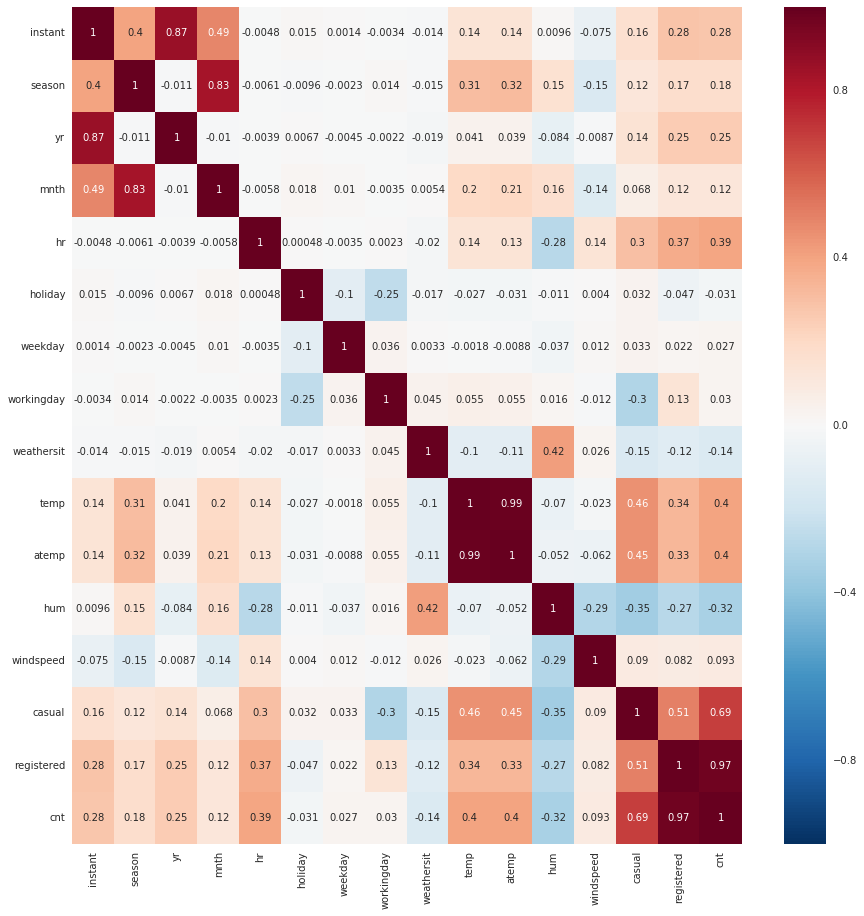

In [21]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix,linecolor="black",annot=True)

In [22]:
def assign_label(x):
    if x>=6 and x<12:
        return 1
    elif x>=12 and x<18:
        return 2
    elif x>=18 and x<24:
        return 3
    elif x>=0 and x<6:
        return 4

In [23]:
bike_rentals["time_label"]=bike_rentals["hr"].apply(assign_label)
bike_rentals["time_label"].head()

0    4
1    4
2    4
3    4
4    4
Name: time_label, dtype: int64

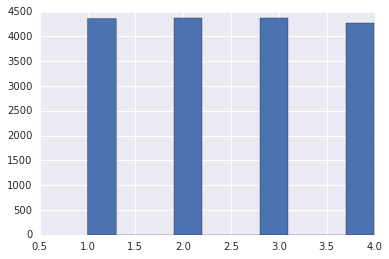

In [24]:
plt.hist(bike_rentals["time_label"])
plt.show()

Давайте определимся с функцией ошибки. Я предлагаю в качестве функции ошибки взять квантильную ошибку, которая будет больше штрафовать за недопрогноз, так как можно говорить о потере прибыли в случае отсутствия необходимого количества велосипедов. Необходимо только подобрать коэфициент квантили.
Предположим, что нам необходимо закупать велосипеды используя банковский  кредит. Нам не выгодно если мы купим велосипед за кредитные деньги будем платить процент за пользование банковскими деньгами, а велосипед при этом будет простаивать. Но нам также не выгодно терять деньги и лояльность клиента если у нас не будет хватать велосипедов для сдачи в аренду, что приведёт к потере прибыли. Для  расчета коэфициента в качестве входных данных возьмем
P-стоимость одного велосипеда
I-месячная процентная ставка
S-стоимость аренды велосипеда в сутки.
Тогда в качестве коэфициента квантили возьмем 1-P*I/30*S
Например если стоимость одного велосипеда 200,месячная процентная ставка по кредиту равна 2 процента и стоимость аренды в сутки равна 8.
Получим, что коэфициент равен 1-200*0.02/30*8 это примерно 0,98.
В нашем случае для примера и простоты приймем коэфициент квантили за 0.8 .


In [25]:
#write the error function
def error_func(targets, predictions,theta):
    summ=0
    for i in range(len(targets)):
        if targets[i]>=predictions[i]:
            summ+=theta*(targets[i]-predictions[i])
        else:
            summ+=(theta-1)*(targets[i]-predictions[i])
    return summ/len(targets)        
        

In [26]:
columns_for_fit=['season','yr','time_label','holiday','weekday','workingday','weathersit','temp','hum','windspeed','cnt']

In [27]:
categorical_columns=['season','time_label','holiday','weekday','workingday','weathersit','cnt']
count_columns=['yr','temp','hum','windspeed']

In [28]:
#work with categorical features
#'holiday' and 'workingday' can not touch
for col in ['season','time_label','weekday','weathersit']:
    dummies_cols=pd.get_dummies(bike_rentals[col],prefix=col,prefix_sep='_')
    for name in dummies_cols.columns:
        columns_for_fit.append(name)
    columns_for_fit.remove(col)
    bike_rentals=pd.concat([bike_rentals,dummies_cols],axis=1)
bike_rentals.head() 
print(columns_for_fit)


['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'time_label_1', 'time_label_2', 'time_label_3', 'time_label_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4']


In [29]:
train=bike_rentals[columns_for_fit].sample(frac=0.8,axis=0)
test=bike_rentals.loc[bike_rentals.index.isin(train.index),columns_for_fit]

In [30]:
columns_for_fit.remove('cnt')
print(columns_for_fit)

['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'time_label_1', 'time_label_2', 'time_label_3', 'time_label_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4']


In [31]:
lr=LinearRegression()
lr.fit(train[columns_for_fit],train['cnt'])
predictions=lr.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--48.73595626843119
value of RMSE--128.78009226135285


In [32]:
print('average "cnt"--{}'.format(bike_rentals['cnt'].mean()))

average "cnt"--189.46308763450142


Следует отметить, что значение ошибок на тестовой выборке очень велики в сравнении с средим количеством "cnt". Можно сказать, что наша модель плохо улавливает закономерность в данных.  Необходимо использовать другие подходы.

Попробуем использовать DecisionTreeRegressor.


In [33]:
dr=DecisionTreeRegressor()
dr.fit(train[columns_for_fit],train['cnt'])
predictions=dr.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--1.8776475101297072
value of RMSE--18.68476678906854


Поиграемся с параметрами.

In [34]:
dr=DecisionTreeRegressor(min_samples_leaf=5,max_depth=5)
dr.fit(train[columns_for_fit],train['cnt'])
predictions=dr.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--43.203694104681766
value of RMSE--123.7727827388478


In [35]:
dr=DecisionTreeRegressor(min_samples_leaf=2,max_depth=15)
dr.fit(train[columns_for_fit],train['cnt'])
predictions=dr.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--22.567537575363247
value of RMSE--75.92748361836885


In [36]:
dr=DecisionTreeRegressor(max_depth=30)
dr.fit(train[columns_for_fit],train['cnt'])
predictions=dr.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--1.9126519456232456
value of RMSE--18.885961717032657


In [37]:
dr=DecisionTreeRegressor(splitter="random")
dr.fit(train[columns_for_fit],train['cnt'])
predictions=dr.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--1.8776475101297072
value of RMSE--18.68476678906854


Используем для построения модели RandomForestRegressor

In [38]:
rf=RandomForestRegressor()
rf.fit(train[columns_for_fit],train['cnt'])
predictions=rf.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))


value of our quantile error--15.00421372399923
value of RMSE--50.578819546308495


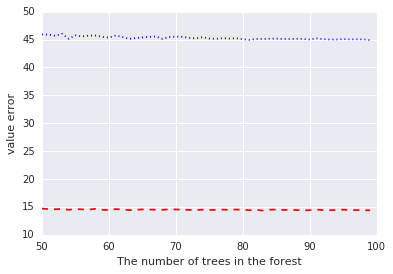

min RMSE - 44.887175664946696
value of n_estimators for min RMSE - 99
min error - 14.343505108595254
value of n_estimators for min error - 83


In [39]:
list_error=[]
min_error=100
n_est_error=0
list_RMSE=[]
min_RMSE=100
n_est_rmse=0
for i in range(50,100):
    rf=RandomForestRegressor( n_estimators = i,max_features=2)
    rf.fit(train[columns_for_fit],train['cnt'])
    predictions=rf.predict(test[columns_for_fit])
    theta=0.8
    error_lr=error_func(list(test['cnt']), list(predictions),theta)
    RMSE=mean_squared_error(test['cnt'],predictions)**.5
    list_error.append(error_lr)
    list_RMSE.append(RMSE)
    if min_error>error_lr:
        min_error=error_lr
        n_est_error=i
    if min_RMSE>RMSE:
        min_RMSE=RMSE
        n_est_rmse=i
        
        
plt.plot(range(50,100),list_error,color='red', linestyle='dashed',label='error')
plt.plot(range(50,100),list_RMSE,color='blue', linestyle='dotted',label='RMSE')
plt.xlabel('The number of trees in the forest')
plt.ylabel('value error')
plt.show()
print('min RMSE - {}'.format(RMSE))
print('value of n_estimators for min RMSE - {}'.format(n_est_rmse))
print('min error - {}'.format(min_error))
print('value of n_estimators for min error - {}'.format(n_est_error))

Используем для построения модели GradientBoostingRegressor

In [49]:
gb_model=GradientBoostingRegressor(loss='ls',learning_rate=0.01,n_estimators=1000,criterion='mse')
gb_model.fit(train[columns_for_fit],train['cnt'])
predictions=gb_model.predict(test[columns_for_fit])
theta=0.8
error_lr=error_func(list(test['cnt']), list(predictions),theta)
RMSE=mean_squared_error(test['cnt'],predictions)**.5
print('value of our quantile error--{}'.format(error_lr))
print('value of RMSE--{}'.format(RMSE))

value of our quantile error--38.66474385792439
value of RMSE--112.34449392679514
